In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os


#Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from tensorflow.keras import backend as K

# def clear_memory():
#     K.clear_session()
#     tf.keras.backend.clear_session()
#     import gc
#     gc.collect()


In [3]:
import os
data= "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/raw/plantvillage dataset/edited"

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

# Check the number of images in each class
class_counts = df['Labels'].value_counts()
print(class_counts)

Labels
Tomato___Tomato_Yellow_Leaf_Curl_Virus           5357
Tomato___Bacterial_spot                          2127
Tomato___Late_blight                             1909
Tomato___Septoria_leaf_spot                      1771
Tomato___Spider_mites Two-spotted_spider_mite    1676
Tomato___healthy                                 1591
Tomato___Target_Spot                             1404
Tomato___Early_blight                            1000
Tomato___Leaf_Mold                                952
Tomato___Tomato_mosaic_virus                      373
Name: count, dtype: int64


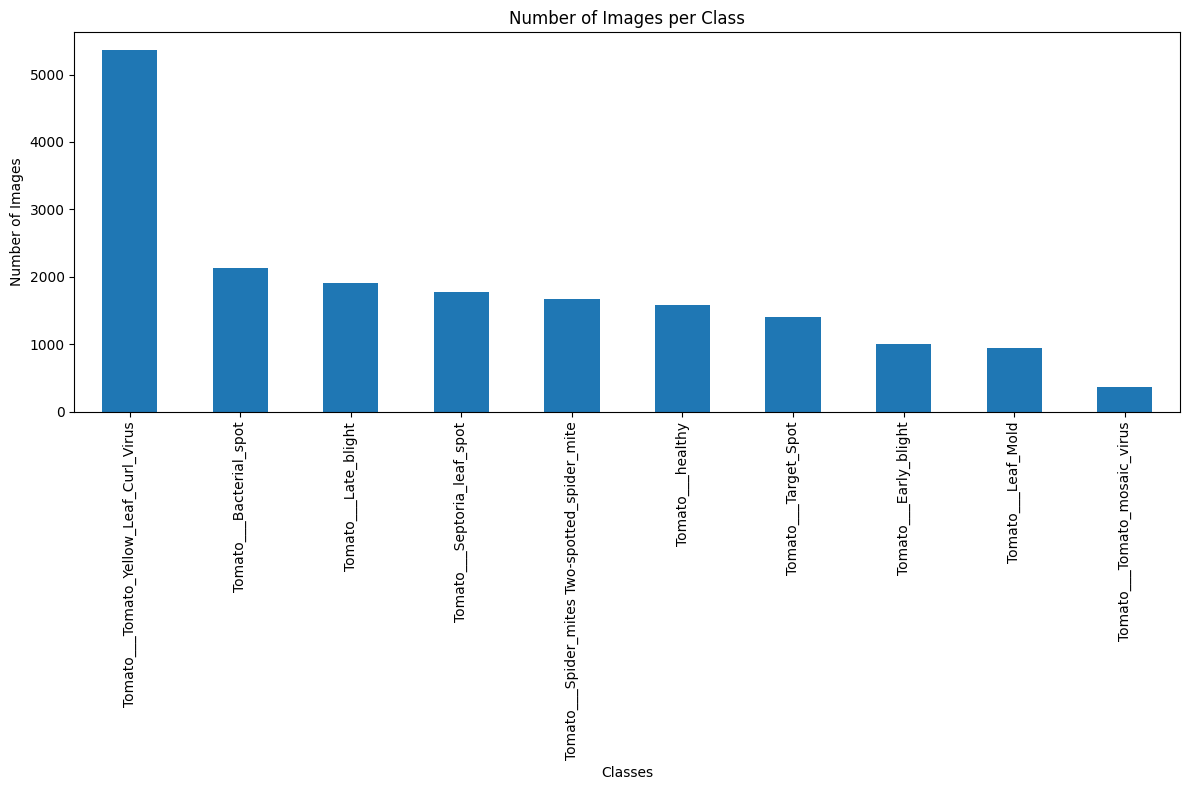

In [4]:
import matplotlib.pyplot as plt

# Plotting the class distribution
class_counts = df['Labels'].value_counts()
plt.figure(figsize=(12,8))
class_counts.plot(kind='bar')
plt.title('Number of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the output directory and train_test_split dir
output_dir = "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/processed"
train_test_valid_dir = "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/raw"

# Create train, valid, and test directories within the output directory
train_dir = os.path.join(train_test_valid_dir, 'train')
valid_dir = os.path.join(train_test_valid_dir, 'valid')
test_dir = os.path.join(train_test_valid_dir, 'test')

# Function to check if directories are empty
def are_directories_empty(directories):
    return all(not os.listdir(directory) for directory in directories)

# Check if the directories already contain files
directories_to_check = [train_dir, valid_dir, test_dir]

if are_directories_empty(directories_to_check):
    # If directories are empty, proceed with splitting and saving images
    # Assuming df is already defined and contains your data
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

    # Save images to directory function
    def save_images(df, base_dir):
        for index, row in df.iterrows():
            label = row['Labels']
            filepath = row['Filepaths']

            # Create class directory if it doesn't exist
            class_dir = os.path.join(base_dir, label)
            os.makedirs(class_dir, exist_ok=True)

            # Copy image to the target directory
            shutil.copy(filepath, class_dir)

    # Save images to corresponding directories
    save_images(train_df, train_dir)
    save_images(valid_df, valid_dir)
    save_images(test_df, test_dir)

    print("Images have been successfully split and saved into the processed directory.")
else:
    print("Data already exists in the directories. Skipping the split and save process.")


Data already exists in the directories. Skipping the split and save process.


In [6]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define paths
output_dir = "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/processed"

threshold = 1200  # Set your threshold for number of images

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count number of images in the directory
def count_images_in_dir(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
    return total_images

# Process each label within train directory
for label in os.listdir(train_dir):
    original_class_dir = os.path.join(train_dir, label)
    class_save_dir = os.path.join(output_dir, label)
    
    if not os.path.exists(original_class_dir):
        print(f"Original class directory '{original_class_dir}' does not exist.")
        continue

    # Count images in directory
    original_count = count_images_in_dir(original_class_dir)
    augmented_count = count_images_in_dir(class_save_dir)
    total_count = original_count + augmented_count

    print(f"Original images for class '{label}': {original_count}")
    print(f"Augmented images for class '{label}': {augmented_count}")
    print(f"Total images for class '{label}': {total_count}")
    
    # test if total count is higher than threshold.
    # If yes, move on
    # if no, continue with augementation
    if total_count >= threshold:
        print(f"Class '{label}' already has enough images. Skipping augmentation.")
        continue
    
    # calculate number of images to generate
    num_to_generate = threshold - total_count
    print(f"Number of images to generate for class '{label}': {num_to_generate}")
    
    # generate if number to generate is more than 0
    if num_to_generate > 0:
        print(f"Augmenting class '{label}' to reach {threshold} images.")
        
        os.makedirs(class_save_dir, exist_ok=True)
        
        # Use ImageDataGenerator to generate augmented images
        generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(128, 128),  # Adjust size as needed
            batch_size=1,
            class_mode=None,  # No labels
            save_to_dir=class_save_dir,
            save_prefix='aug',
            save_format='jpeg',
            classes=[label]  # Only process images from the specific class
        )
        
        num_images_processed = 0
        
        while num_images_processed < num_to_generate:
            batch = next(generator)
            num_images_processed += len(batch)
            if num_images_processed >= num_to_generate:
                break
        
        print(f"Augmentation for class '{label}' completed. {num_images_processed} images generated.")
    else:
        print(f"Class '{label}' does not need additional augmentation.")

print("Data augmentation completed and saved.")

Original images for class 'Tomato___Bacterial_spot': 1719
Augmented images for class 'Tomato___Bacterial_spot': 0
Total images for class 'Tomato___Bacterial_spot': 1719
Class 'Tomato___Bacterial_spot' already has enough images. Skipping augmentation.
Original images for class 'Tomato___Early_blight': 787
Augmented images for class 'Tomato___Early_blight': 413
Total images for class 'Tomato___Early_blight': 1200
Class 'Tomato___Early_blight' already has enough images. Skipping augmentation.
Original images for class 'Tomato___healthy': 1283
Augmented images for class 'Tomato___healthy': 0
Total images for class 'Tomato___healthy': 1283
Class 'Tomato___healthy' already has enough images. Skipping augmentation.
Original images for class 'Tomato___Late_blight': 1524
Augmented images for class 'Tomato___Late_blight': 0
Total images for class 'Tomato___Late_blight': 1524
Class 'Tomato___Late_blight' already has enough images. Skipping augmentation.
Original images for class 'Tomato___Leaf_Mo

In [7]:
# import os
# import shutil

# # Define combined directory
# combined_dir = "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/combined"

# # Create combined directory if it doesn't exist
# if not os.path.exists(combined_dir):
#     os.makedirs(combined_dir)

# # Function to copy images and avoid duplicates
# def copy_images(source_dir, target_dir):
#     if not os.path.exists(target_dir):
#         os.makedirs(target_dir)
    
#     for file in os.listdir(source_dir):
#         src_file = os.path.join(source_dir, file)
#         tgt_file = os.path.join(target_dir, file)
        
#         # Check if the file already exists in the target directory
#         if not os.path.exists(tgt_file):
#             print(f"Copying {src_file} to {tgt_file}")
#             shutil.copy(src_file, tgt_file)
#         else:
#             print(f"File {tgt_file} already exists.")

# # Copy original images from trained_dir to the combined directory
# for label in os.listdir(train_dir):
#     label_dir = os.path.join(train_dir, label)
#     if os.path.isdir(label_dir):
#         target_label_dir = os.path.join(combined_dir, label)
#         copy_images(label_dir, target_label_dir)

# # Copy augmented images from output_dir to the combined directory
# for label in os.listdir(output_dir):
#     label_dir = os.path.join(output_dir, label)
#     if os.path.isdir(label_dir):
#         target_label_dir = os.path.join(combined_dir, label)
#         copy_images(label_dir, target_label_dir)

# print("Images combined into the directory.")

In [8]:
import os

# Define the path to the combined directory
combined_dir = "C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/combined"

# Function to count images in each class
def count_images_in_classes(directory):
    class_counts = {}
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            num_images = len([file for file in os.listdir(label_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[label] = num_images
    
    return class_counts

# Get the counts of images in each class
class_counts = count_images_in_classes(combined_dir)

# Print the number of classes and the number of images in each class
print(f"Total number of classes: {len(class_counts)}\n")
for label, count in class_counts.items():
    print(f"Class '{label}' has {count} images.")


Total number of classes: 10

Class 'Tomato___Bacterial_spot' has 1719 images.
Class 'Tomato___Early_blight' has 1200 images.
Class 'Tomato___healthy' has 1283 images.
Class 'Tomato___Late_blight' has 1524 images.
Class 'Tomato___Leaf_Mold' has 1200 images.
Class 'Tomato___Septoria_leaf_spot' has 1414 images.
Class 'Tomato___Spider_mites Two-spotted_spider_mite' has 1315 images.
Class 'Tomato___Target_Spot' has 1200 images.
Class 'Tomato___Tomato_mosaic_virus' has 1200 images.
Class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' has 4329 images.


In [9]:
# import shutil
# import os
# import random
# import numpy as np

# def undersample_class(directory, target_num_images):
#     for label in os.listdir(directory):
#         label_dir = os.path.join(directory, label)
#         if os.path.isdir(label_dir):
#             images = [f for f in os.listdir(label_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#             if len(images) > target_num_images:
#                 selected_images = random.sample(images, target_num_images)
#                 for image in images:
#                     if image not in selected_images:
#                         os.remove(os.path.join(label_dir, image))


# # Count the number of images in each class directory
# def count_images_in_dir(directory):
#     total_images = 0
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 total_images += 1
#     return total_images

# # Initialize a dictionary to store class counts
# new_class_count = {}

# # Iterate over each class directory in the combined directory
# for label in os.listdir(combined_dir):
#     label_dir = os.path.join(combined_dir, label)
#     if os.path.isdir(label_dir):
#         # Count the number of images in the current class directory
#         class_count = count_images_in_dir(label_dir)
#         new_class_count[label] = class_count
#         print(f"Class '{label}' has {class_count} images.")

# # Convert new_class_count to a list of counts if it's a dictionary
# if isinstance(new_class_count, dict):
#     new_class_count = list(new_class_count.values())

# # Find the minimum number of images among all classes
# target_num_images = min(new_class_count) if new_class_count else 0
# print(f"Target number of images for undersampling: {target_num_images}")

# # Undersample classes if necessary
# undersample_class(combined_dir, target_num_images)


In [10]:
# Define ImageDataGenerator for training, validation, and testing
train_datagens = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generator to read from the combined directory
train_generator = train_datagens.flow_from_directory(
    directory=combined_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation and test data from directories
valid_generator = valid_datagen.flow_from_directory(
    directory="C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/raw/valid",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory="C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/data/raw/test",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 16384 images belonging to 10 classes.
Found 1816 images belonging to 10 classes.
Found 1816 images belonging to 10 classes.


In [11]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

# Get class labels from the generator
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Initialize a dictionary to count the number of samples for each class
class_counts = {class_name: 0 for class_name in class_labels}

# Iterate over the batches to count the number of samples in each class
for batch in train_generator:
    x_batch, y_batch = batch
    # Count occurrences of each class in the batch
    y_batch_classes = np.argmax(y_batch, axis=1)
    unique, counts = np.unique(y_batch_classes, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[class_labels[cls]] += count
    
    # Stop after one epoch (or adjust based on your needs)
    break

# Calculate class weights
total_samples = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = {i: total_samples / (num_classes * class_counts[class_name]) for i, class_name in enumerate(class_labels)}

print('Class Weights:', class_weights)


Class Weights: {0: 1.0666666666666667, 1: 3.2, 2: 1.6, 3: 1.0666666666666667, 4: 0.64, 5: 1.0666666666666667, 6: 0.8, 7: 0.45714285714285713, 8: 1.6, 9: 1.6}


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define base model
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='max')

for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 7,306,570
Trainable params: 267,018
Non-trainable params: 7,039,552
________________________________________

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compile the model
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('DenseNet_best_model.h5', save_best_only=True, monitor='val_loss')

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7  # Minimum learning rate
)


# clear_memory()

# Training
history = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=50,
    batch_size=32,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/50
512/512 [==============================] - 55s 88ms/step - loss: 4.8515 - accuracy: 0.5207 - val_loss: 3.4642 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 2/50
512/512 [==============================] - 43s 83ms/step - loss: 3.1836 - accuracy: 0.7328 - val_loss: 2.6055 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 3/50
512/512 [==============================] - 44s 85ms/step - loss: 2.5161 - accuracy: 0.7958 - val_loss: 2.1234 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 4/50
512/512 [==============================] - 44s 86ms/step - loss: 2.0775 - accuracy: 0.8291 - val_loss: 1.7753 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 5/50
512/512 [==============================] - 46s 90ms/step - loss: 1.7382 - accuracy: 0.8511 - val_loss: 1.4924 - val_accuracy: 0.8849 - lr: 1.0000e-04
Epoch 6/50
512/512 [==============================] - 47s 92ms/step - loss: 1.4723 - accuracy: 0.8685 - val_loss: 1.2747 - val_accuracy: 0.8910 - lr: 1.0000e-04
Epoch 7/50
512/512 [==============

In [14]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.regularizers import l2

# base_model = tf.keras.applications.Xception(weights= 'imagenet' ,include_top = False , input_shape = (128,128,3) ,
#                                                      pooling = 'max' )

# # Define the model
# model = Sequential([
#     base_model,
#     BatchNormalization(),
#     Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
#     Dropout(0.5),
#     Dense(10, activation='softmax')
# ])

# optimizer = Adam(learning_rate=1e-5)

# model.compile(optimizer=optimizer , loss = 'categorical_crossentropy' , metrics= ['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 0.9 ** epoch)

# batch_size = 32

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# history = model.fit(
#     x=train_generator,
#     validation_data=valid_generator,
#     epochs=10,  # Start with a smaller number of epochs
#     batch_size=batch_size,
#     verbose=1,
#     callbacks=[early_stopping, model_checkpoint, lr_scheduler]
# )



In [15]:
import pickle

# Save the model
model.save('C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/models/DenseNet_Model.h5')

# Save the history
with open('C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/history/DenseNet_Model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load the model
loaded_model = keras.models.load_model('C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/models/DenseNet_Model.h5')

# Predict on test data
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = test_generator.classes  # or obtain from test_generator

# Generate classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

57/57 [==============================] - 6s 81ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.96      0.96      0.96       224
                        Tomato___Early_blight       0.87      0.88      0.88       111
                         Tomato___Late_blight       0.93      0.96      0.94       215
                           Tomato___Leaf_Mold       0.93      0.83      0.88       102
                  Tomato___Septoria_leaf_spot       0.93      0.85      0.89       171
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.95      0.92       176
                         Tomato___Target_Spot       0.82      0.82      0.82       117
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       493
                 Tomato___Tomato_mosaic_virus       1.00      0.97      0.99        36
                             Tomato___healthy       0.97      0.98      0.9

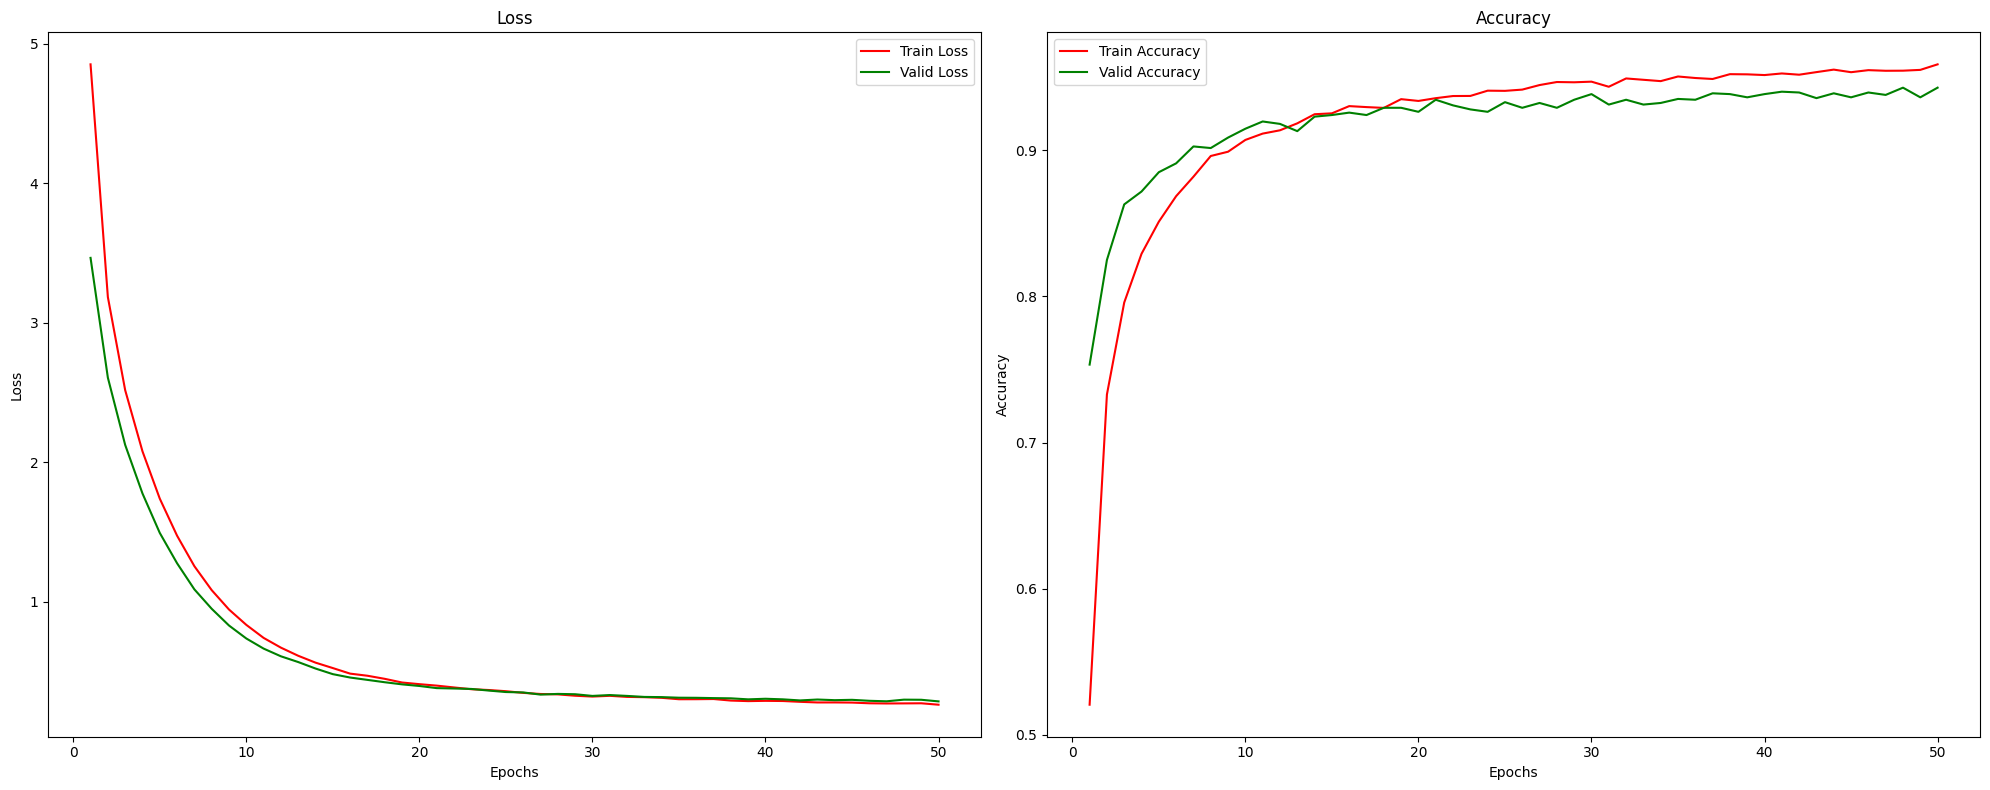

In [17]:
import pickle

# Open the file in read mode to load the history
with open('C:/Users/User/OneDrive/Documents/FYP/Computer_Vision_FYP/Codes/history/DenseNet_Model_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Now you can access the history data
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = [i + 1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [18]:
# Compute metrics
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

57/57 [==============================] - 7s 82ms/step - loss: 0.2862 - accuracy: 0.9389
Accuracy: 0.9388766288757324
Precision: 0.9394150983221254
Recall: 0.9388766519823789
F1 Score: 0.9386424245955383


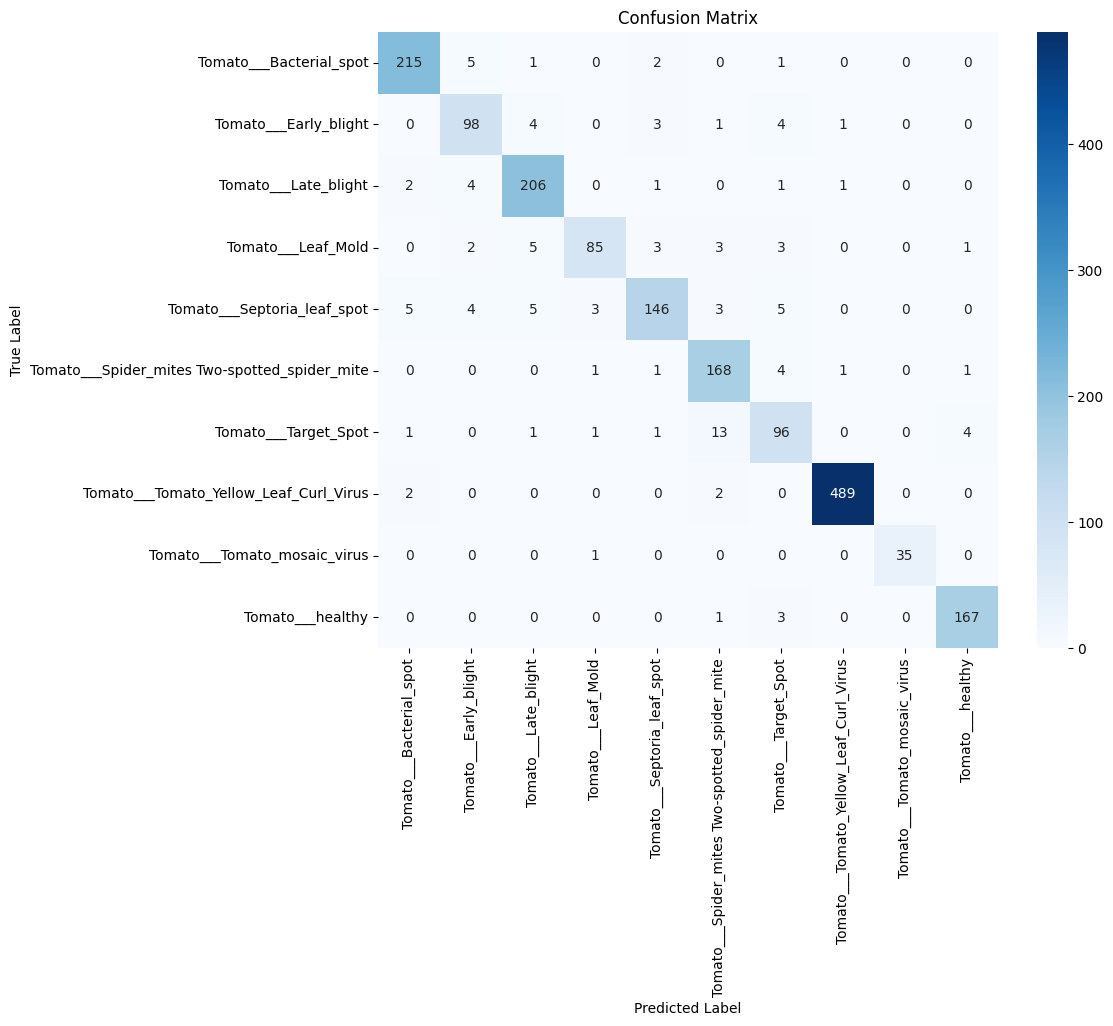

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


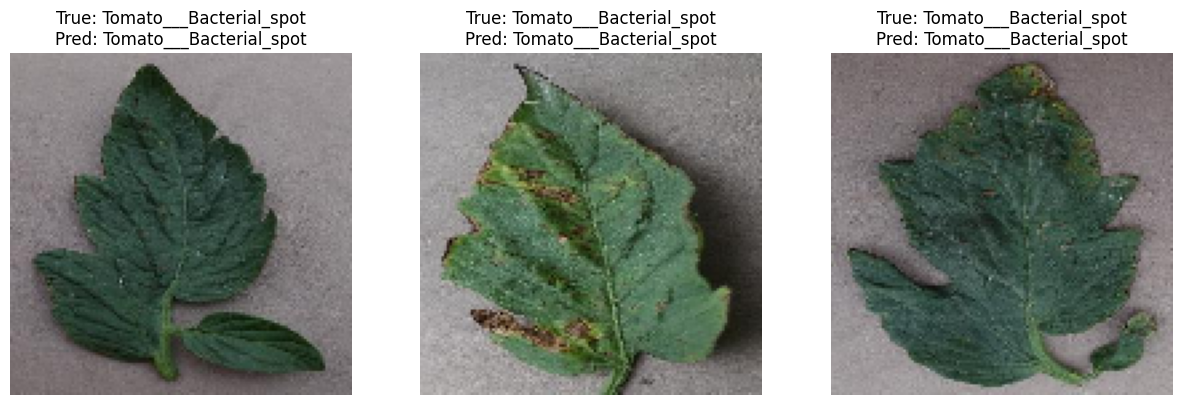

In [20]:
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Invert the dictionary

# Displaying a few sample predictions with their true labels
def display_predictions(generator, model, num_images=5):
    x_test, y_test = next(generator)  # Get a batch of images and labels
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_test[i])
        true_label = class_labels[true_classes[i]]
        pred_label = class_labels[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

# Display predictions for the first batch of test data
display_predictions(test_generator, loaded_model, num_images=3)